In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random



In [17]:
def find_rooms(img, noise_removal_threshold=25, corners_threshold=0.01,
               room_closing_max_length=100, gap_in_wall_threshold=50):
    """

    :param img: grey scale image of rooms, already eroded and doors removed etc.
    :param noise_removal_threshold: Minimal area of blobs to be kept.
    :param corners_threshold: Threshold to allow corners. Higher removes more of the house.
    :param room_closing_max_length: Maximum line length to add to close off open doors.
    :param gap_in_wall_threshold: Minimum number of pixels to identify component as room instead of hole in the wall.
    :return: rooms: list of numpy arrays containing boolean masks for each detected room
             colored_house: A colored version of the input image, where each room has a random color.
    """
    assert 0 <= corners_threshold <= 1
    # Remove noise left from door removal

    img[img < 128] = 0
    img[img > 128] = 255
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(img)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 255)

    img = ~mask

    # Detect corners (you can play with the parameters here)
    dst = cv2.cornerHarris(img ,2,3,0.04)
    dst = cv2.dilate(dst,None)
    corners = dst > corners_threshold * dst.max()

    # Draw lines to close the rooms off by adding a line between corners on the same x or y coordinate
    # This gets some false positives.
    # You could try to disallow drawing through other existing lines for example.
    for y,row in enumerate(corners):
        x_same_y = np.argwhere(row)
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):

            if x2[0] - x1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x1, y), (x2, y), color, 1)

    for x,col in enumerate(corners.T):
        y_same_x = np.argwhere(col)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            if y2[0] - y1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x, y1), (x, y2), color, 1)


    # Mark the outside of the house as black
    contours, hierarchy = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(mask)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 0

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    rooms = []
    for label in unique:
        component = labels == label
        if img[component].sum() == 0 or np.count_nonzero(component) < gap_in_wall_threshold:
            color = 0
        else:
            rooms.append(component)
            color = np.random.randint(0, 255, size=3)
        img[component] = color

    return rooms, img


In [18]:
def get_bearing_walls(origianl_image):
    gray = cv2.cvtColor(origianl_image, cv2.COLOR_RGB2GRAY)

    # binary inverse thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    plt.figure(figsize = (60,6))
    plt.imshow(thresh, cmap='gray')
    plt.title('thresh')
    plt.xticks([]), plt.yticks([])
    plt.show()

    kernel = np.ones((3, 3), np.float32)
    bearing_walls = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    


    # _, bearing_walls_inv = cv2.threshold(bearing_walls, 127, 255, cv2.THRESH_BINARY_INV)

    return bearing_walls


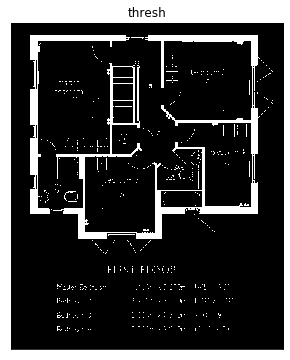

In [19]:
#read the image

img_path = "../Data/floorplans_VOA/DFirstFloor.jpg"
original_image = cv2.imread(img_path)


img_copy = original_image.copy()
a, b, c = original_image.shape
blank_img = np.zeros([a, b, c], np.uint8)
blank_img.fill(255)

room_bounary_contours = blank_img.copy()

bearing_walls = get_bearing_walls(original_image)



In [20]:
rooms1, colored_rooms = find_rooms(bearing_walls.copy())
colored_rooms1 = colored_rooms.copy()

gray2 = cv2.cvtColor(colored_rooms1, cv2.COLOR_BGR2GRAY)
_, thresh2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY_INV)

# draw contours over colored rooms
contours2, hierachy2 = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for c in contours2:
    cv2.drawContours(room_bounary_contours, [c], -1,
                     (random.randrange(0, 200), random.randrange(0, 200), random.randrange(0, 200))
                     , 2)

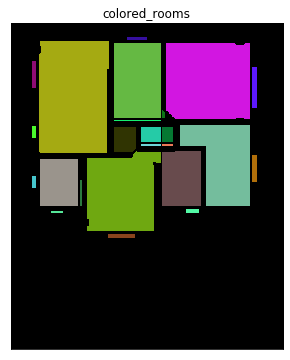

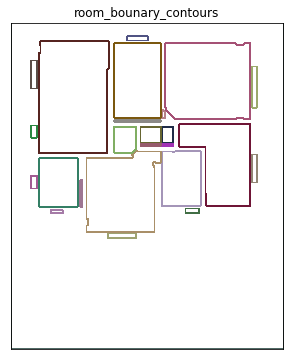

In [21]:
plt.figure(figsize = (60,6))
plt.imshow(colored_rooms, cmap='gray')
plt.title('colored_rooms')
plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize = (60,6))
plt.imshow(room_bounary_contours, cmap='gray')
plt.title('room_bounary_contours')
plt.xticks([]), plt.yticks([])
plt.show()